# Generate plots from saved runs

In [1]:
import warnings
import matplotlib
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

In [2]:
# %matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
from src.microcircuit import *
from src.save_exp import *
import sys
# import pandas as pd
from scipy.stats import sem

plt.style.use('./matplotlib_style.mplstyle')
cm_to_inch = 1/2.54  # centimeters in inches
pagewidth = 17 # width in cm

#load autoreload, which automatically reloads the microcircuit.py upon execution
%reload_ext autoreload
%autoreload 1
%aimport src.microcircuit

In [3]:
def moving_average(x, w, n_repeat=None):
    if n_repeat==None:
        n_repeat = w
    x = np.repeat(x[::n_repeat], n_repeat, axis=0)
    return np.convolve(x, np.ones(w), 'valid') / w

# Fig 2b: DMS task

In [16]:
MAIN_PATH = 'experiments/Fig2b_DMS_plots/'

In [17]:
model_file = MAIN_PATH + '/model.pkl'
MC_list = src.save_exp.load(model_file)

In [20]:
SEEDS = 10
EPOCHS = 15

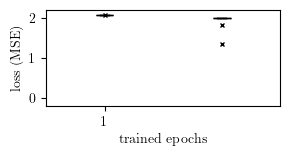

In [21]:
fig, ax = plt.subplots(figsize=(pagewidth*cm_to_inch/2, pagewidth*cm_to_inch/5))

colors = [ 'C1']

# data = np.array([mc.MSE_val_time_series for mc in MC_list])
# # rearrange into epochs
# data = data.reshape(SEEDS, EPOCHS, -1)

# median = np.median(data, axis=[0,-1])
# q25, q75  = np.quantile(data, 0.25, axis=[0,-1]), np.quantile(data, 0.75, axis=[0,-1])

# plt.errorbar(np.arange(len(median)), median, yerr=np.vstack([median-q25, q75-median]), ls='none', marker='o', capsize=2, c='C1', markersize=3)


# data = np.array([mc.MSE_test_time_series for mc in MC_list])
# # rearrange into epochs
# data = data.reshape(SEEDS, 1, -1)

# median = np.median(data, axis=[0,-1])
# q25, q75  = np.quantile(data, 0.25, axis=[0,-1]), np.quantile(data, 0.75, axis=[0,-1])

# plt.errorbar(15, median, yerr=np.vstack([median-q25, q75-median]), ls='none', marker='D', capsize=2,
#             c='C1', markersize=3)

# plt.xticks(np.arange(1, 10, 2))

data_val = np.array([mc.MSE_val_time_series for mc in MC_list])
data_test = np.array([mc.MSE_test_time_series for mc in MC_list])

data = np.concatenate((data_val, data_test), axis=1)
data = data.reshape(SEEDS, EPOCHS+1, -1)
# mean over val/test per epoch
data = np.mean(data, axis=-1)

xpos = np.arange(1, len(data[0])+1, 1)

flierprops = dict(marker='x', markerfacecolor='None', markersize=3,  markeredgecolor='black')
bplot = plt.boxplot(data, patch_artist=True, flierprops=flierprops, positions=xpos)

# fill with colors
for patch in bplot['boxes']:
    patch.set_facecolor(colors[0])
for median in bplot['medians']:
    median.set_color('black')


plt.xlabel("epoch")
plt.ylabel("MSE loss")
# plt.title("Validation loss (median and quartile)")

plt.ylim(-.2,2.2)
plt.yticks([0,1,2])



plt.xticks(np.arange(1, EPOCHS+1, 2))
ax.set_xticklabels(np.arange(1, EPOCHS+1, 2))

plt.xlabel("trained epochs")
plt.ylabel("loss (MSE)")
plt.subplots_adjust(left = 0.27, top = 0.97, right = 0.97, bottom = 0.25, hspace = 0.2, wspace = 0.0)

plt.savefig(MAIN_PATH + "MSE_val_test.pdf", bbox_inches="tight")
plt.show()

In [22]:
import DMS_task as dms

In [23]:
mc1 = MC_list[0]
mc2 = MC_list[1]

/Users/km/owncloud/Projects Neuro/code_submissions/error-mc/numpy_model/src/microcircuit.py:29: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-10.0*x))*slope


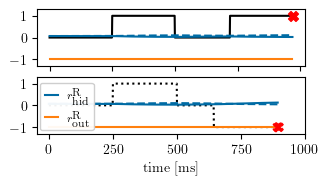

In [24]:
fig, ax = plt.subplots(nrows=2, figsize=(pagewidth*cm_to_inch/2.1, pagewidth*cm_to_inch/3.5))

for first_stim in [+1]:
    for j, (second_stim, ls) in enumerate(zip([+1, -1], ['solid', '--'])):

        # try one input
        input_ideal, target_ideal = dms.generate_inputs_and_targets(1,
                                                                    seed=j,
                                                                    first_stim=first_stim,
                                                                    second_stim=second_stim)
        inputs = input_ideal[0]
        target = target_ideal[0]

        # re-init recording of params
        mc1.init_record(rec_per_steps=1,
                        rec_uI_breve=True, rec_uP_breve=True, 
                        rec_rI_breve=True, rec_rP_breve=True,
                        rec_uP=True, rec_uI=True, 
                        rec_WPP=True, rec_BII=True, rec_WIP=True, rec_BPI=True, rec_vapi=True,
                        rec_MSE=True
                       )
        # reset voltage
        mc1.set_voltages(uP=mc1.uP_init)

        for i in range(len(inputs)):
            mc1.evolve_system(r0=[inputs[i]], learn_weights=False)

        ax[j].plot(inputs, c='black', ls='solid' if j==0 else 'dotted')#, label="input" if j==0 else None)
        ax[j].scatter(len(inputs)+1, target, ls=ls, marker='X', s=50, c=f"red", zorder=100)#, label="target" if j==0 else None)
              
        #set random weights
        mc2.WPP[0] = np.array([[1],[1.0]]) * 5
        mc2.WPP[1] = np.array([[2.0,-1.0]])

        # re-init recording of params
        mc2.init_record(rec_per_steps=1,
                        rec_uI_breve=True, rec_uP_breve=True, 
                        rec_rI_breve=True, rec_rP_breve=True,
                        rec_uP=True, rec_uI=True, 
                        rec_WPP=True, rec_BII=True, rec_WIP=True, rec_BPI=True, rec_vapi=True,
                        rec_MSE=True
                       )
        # reset voltage
        mc2.set_voltages(uP=mc2.uP_init)
        
        for i in range(len(inputs)):
            mc2.evolve_system(r0=[inputs[i]], learn_weights=False)

#         x = [v[0] for v in mc2.rP_breve_time_series]
#         x = np.array(x)
#         ax[j].plot(x, ls='dashed', c=f"C0", label="$r^\\textrm{P}_\\textrm{hid}$ (init.)" if j==0 else None, zorder=50)

#         x = [v[-1] for v in mc2.rP_breve_time_series]
#         x = np.array(x)
#         ax[j].plot(x.ravel(), ls='solid', c=f"C0",label="$r^\\textrm{P}_\\textrm{out}$ (init.)" if j==0 else None, zorder=50)

        x = [v[0] for v in mc1.rP_breve_time_series]
        x = np.array(x).T
        ax[j].plot(x[0], ls='solid', c=f"C0", label="$r^\\textrm{R}_\\textrm{hid}$" if j==1 else None, zorder=50)
        ax[j].plot(x[1], ls='dashed', c=f"C0", zorder=50)

        x = [v[-1] for v in mc1.rP_breve_time_series]
        x = np.array(x)
        ax[j].plot(x.ravel(), ls='solid', c=f"C1",label="$r^\\textrm{R}_\\textrm{out}$" if j==1 else None, zorder=51)
        
 

        ax[j].set_ylim(-1.3,1.3)
#         plt.grid()

# plt.title(str(first_stim) + ", " + str(second_stim))
        ax[j].set_xticks([0,250,500,750,1_000])
    
# plt.tight_layout()
ax[0].tick_params(labelbottom=False)    
leg = ax[1].legend(framealpha = 0.95, prop={'size': 8}, loc='upper center', handlelength=1.2, bbox_to_anchor=(0.11, 1.))#ncol=1, labelspacing=-1.1, bbox_to_anchor=(0.5, 1.5))
leg.set_zorder(102)
leg.get_frame().set_facecolor('w')
# l = ax[0].legend(prop={'size': 8}, loc='upper center', ncol=4, handlelength=0.75, bbox_to_anchor=(0.5, 1.7), columnspacing=1, handletextpad=0.6)
# l.get_texts()[-1].set_va('baseline')

plt.xlabel('time [ms]')
# plt.ylabel('')
plt.subplots_adjust(left = 0.1, top = 0.9, right = 0.94, bottom = 0.25, hspace = 0.2, wspace = 0.0)
# plt.tight_layout()
plt.savefig(MAIN_PATH + '/example.pdf')
plt.show()


In [25]:
# fig, ax = plt.subplots(nrows=1, figsize=(4.9, 3.5/2))

# for first_stim in [+1,-1]:
#     for j, (second_stim, ls) in enumerate(zip([+1, -1], ['solid', '--'])):

#         # try one input
#         input_ideal, target_ideal = dms.generate_inputs_and_targets(1,
#                                                                     seed=j,
#                                                                     first_stim=first_stim,
#                                                                     second_stim=second_stim)
#         inputs = input_ideal[0]
#         target = target_ideal[0]  

#         ax.plot(inputs, c='black')
#         ax.scatter(len(inputs)+1, target, ls=ls, marker='X', s=50, c=f"red", label="target" if j==0 else None, zorder=100)
        
# ax.plot([], label="input", c='black')

# ax.set_ylim(-1.2,1.2)
# ax.set_xticks([0,250,500,750,1_000])
    
# plt.tight_layout()

# ax.legend(prop={'size': 10}, loc='upper center', ncol=4, labelspacing=-1.1, bbox_to_anchor=(0.5, 1.5))
# plt.xlabel('time [ms]')
# # plt.ylabel('')


# # plt.savefig(MAIN_PATH + '/example.pdf', dpi=200, bbox_inches="tight")
# plt.show()


# Figure 3 and A1: comparison

## Load microcircuits

In [4]:
MAIN_PATH = 'experiments/Fig3_multilayer_comparison/'
# MAIN_PATH = 'experiments/FigA1_multilayer_comparison_hierarchical/' # uncomment for Fig A1
PATHS = ['/2-1/','/4-2-1/','/8-4-2-1/','/16-8-4-2-1/','/32-16-8-4-2-1/']
PATH_APPENDIX = ['ann', 'errormc', 'dPC', 'sacramento2018', 'untrained_ann', 'untrained_errormc', 'untrained_dPC', 'untrained_sacramento2018']
NAME = ''

In [5]:
network_MC_list = []
for PATH in PATHS:
    for PATH_APP in PATH_APPENDIX:
        model_file = MAIN_PATH + PATH + '/' + PATH_APP + '/model.pkl'
        MC_list = src.save_exp.load(model_file)
        network_MC_list.append(MC_list)

In [6]:
# define the number of recorded time steps which belong to the pre-training
# and therefore should be skipped in plotting
TPRE = int(MC_list[0].settling_time / MC_list[0].dt / MC_list[0].rec_per_steps)

linestyles = ['dotted', 'dashdot', 'dashed','solid']
plt.rc('text', usetex=True)
plt.rc('font', size=12,family='serif')

LABEL_MULTIPLIER = int(1/ MC_list[0].rec_per_steps * MC_list[0].Tpres * MC_list[0].dataset_size / MC_list[0].dt)

## Reorder data

Clean up the code and order different MCs:

In [7]:
network_MC_list_clean = []
tmp_MC_list = []

# skip teacher
tmp_MC_list = [MC_list[1:] for MC_list in network_MC_list]
     
# Step 1: Split the list into chunks of 8 elements
chunks = [tmp_MC_list[i:i+8] for i in range(0, len(tmp_MC_list), 8)]

# Step 2: Reorganize each chunk
result = []
for chunk in chunks:
    for i in range(4):  # 4 pairs in each chunk
        network_MC_list_clean.append([chunk[i], chunk[i+4]])
    

In [8]:
mean_std_arr = []
# the MSE needs a little bit to settle, which heavily distorts the MSE
# therefore, we skip a couple of dt
SKIP_SETTLING = 10

for i, [MC_list, MC_list_untrained] in enumerate(network_MC_list_clean):
    # extract MSE
    data = np.array([mc.MSE_test_time_series for mc in MC_list])
    data = data[:,SKIP_SETTLING:]
    # first, take mean over test accuracy (time)
    data = np.mean(data, axis=-1)
    
    # then, median over seeds
    mean = np.median(data)
    std  = (np.quantile(data, q=.25), np.quantile(data, q=.75))
#     std  = (np.std(data))
    
    # extract MSE
    data_untrnd = np.array([mc.MSE_test_time_series for mc in MC_list_untrained])
    data_untrnd = data_untrnd[:,SKIP_SETTLING:]
    # first, take mean over test accuracy (time)
    data_untrnd = np.mean(data_untrnd, axis=-1)
    
    # then, median over seeds
    mean_untrained = np.median(data_untrnd)
    std_untrained  = (np.quantile(data_untrnd, q=.25), np.quantile(data_untrnd, q=.75))
#     std_untrained  = (np.std(data))
    
    mean_std_arr.append([[mean, std], [mean_untrained, std_untrained]])
# mean_std_arr = np.array(mean_std_arr)

## Bars next to eachother

In [9]:
MSE_data = []
# the MSE needs a little bit to settle, which heavily distorts the MSE
# therefore, we skip a couple of dt
SKIP_SETTLING = 10

for i, [MC_list, MC_list_untrained] in enumerate(network_MC_list_clean):
    # extract MSE
    data = np.array([mc.MSE_test_time_series for mc in MC_list])
    data = data[:,SKIP_SETTLING:]
    # first, take mean over test accuracy (time)
    data = np.mean(data, axis=-1)
    
    # extract MSE
    data_untrnd = np.array([mc.MSE_test_time_series for mc in MC_list_untrained])
    data_untrnd = data_untrnd[:,SKIP_SETTLING:]
    # first, take mean over test accuracy (time)
    data_untrnd = np.mean(data_untrnd, axis=-1)
    
    MSE_data.append([data, data_untrnd])
# mean_std_arr = np.array(mean_std_arr)

In [11]:
angle_data_arr = []

for i, MC_list in enumerate(network_MC_list_clean):
#     # skip ANN
#     if i % 3 == 0:
#         continue
    angle_data = [MC_list[0][i].angle_BP_updates_time_series for i in range(len(MC_list[0]))]
    angle_data = np.array(angle_data)
    # replace nan with 0 (can occur due to underflow)
    angle_data = np.nan_to_num(angle_data)
    # mean over time
    angle_data = np.mean(angle_data, axis=1)
    
#     mean = np.mean(angle_data)
#     std  = (np.quantile(angle_data, q=.25), np.quantile(angle_data, q=.75))
#     #     std  = np.std(angle_data)
    
    angle_data_arr.append(angle_data)

[ 1.2  1.9  2.6  3.8  4.5  5.2  6.4  7.1  7.8  9.   9.7 10.4 11.6 12.3
 13. ]


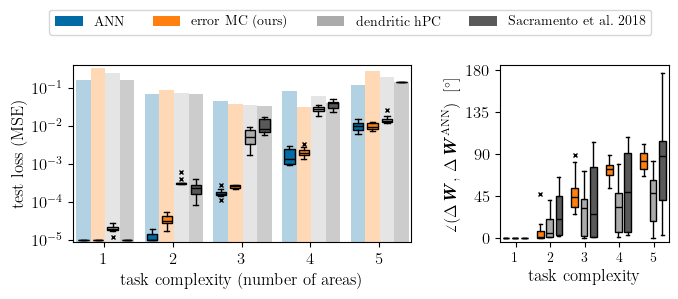

In [12]:
LINTRESH = 1e-5

fig, axes = plt.subplots(figsize=(pagewidth*cm_to_inch, pagewidth*cm_to_inch/2.3), ncols=2, gridspec_kw={'width_ratios': [2, 1]})

ax = axes[0]

ax.set_xlabel("task complexity (number of areas)")
ax.set_ylabel("test loss (MSE)")
if LINTRESH > 0:
    ax.set_yscale('symlog', linthresh=LINTRESH)
else:
    ax.set_yscale('log')

labels = []
colors = []
model_labels = []
for i, [MC_list, MC_list_untrained] in enumerate(network_MC_list_clean):
    if i % 4 == 0:
        model_label = 'ANN'
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
#         label = model_label + ' ' + str(MC_list[-1].layers)
        label = str(MC_list[-1].layers)
        model_labels.append(model_label)
        labels.append(label)
        colors.append(color)        
    elif i % 4 == 1:
#         model_label = 'error MC (hierarchical)'
        model_label = 'error MC (ours)'
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
#         label = model_label + ' ' + str(MC_list[-1].layers)
        label = str(MC_list[-1].layers)
        model_labels.append(model_label)
        labels.append(label)
        colors.append(color)
    elif i % 4 == 2:
        model_label = 'dendritic hPC'
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
#         label = model_label + ' ' + str(MC_list[-1].layers)
        label = str(MC_list[-1].layers)
        model_labels.append(model_label)
        labels.append(label)
        colors.append(color)
    elif i % 4 == 3:
        model_label = 'Sacramento et al.~2018'
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
#         label = model_label + ' ' + str(MC_list[-1].layers)
        label = str(MC_list[-1].layers)
        model_labels.append(model_label)
        labels.append(label)
        colors.append(color)



x_pos = np.arange(len(labels))

width = 0.35  # the width of the bars
multiplier = 0
x_pos = [0]
for i, ([data,untrained_data]) in enumerate(MSE_data):
   
    x_pos.append(x_pos[-1] + width * 2)
    if i == 0: x_pos = x_pos[1:]
    if i > 0 and i % 4 == 0:
        x_pos[-1] += 0.5
    ax.bar(x_pos[-1], np.median(untrained_data), align='center', capsize=4, color=colors[i], \
           width=2*width, alpha=0.3, zorder=-10, error_kw={'alpha': 0.2}) # without error bars
        
MSE_trained_data = np.array([data[0] for data in MSE_data])
# print(len(MSE_trained_data), len(x_pos))
# make sure that small losses are plotted, too
MSE_trained_data[MSE_trained_data < LINTRESH] = LINTRESH
MSE_trained_data = [x for x in MSE_trained_data]

# print(MSE_trained_data.shape, x_pos.shape)

flierprops = dict(marker='x', markerfacecolor='None', markersize=3,  markeredgecolor='black')
bplot_mse = ax.boxplot(MSE_trained_data, positions=x_pos, patch_artist=True, flierprops=flierprops)

# fill with colors
for patch, color in zip(bplot_mse['boxes'], colors):
    patch.set_facecolor(color)
for median in bplot_mse['medians']:
    median.set_color('black')

# ax.set_xticks([])
ax.set_xticks(np.array(x_pos[1::4])+0.3)
# ax.set_xticklabels([l.replace(", ", "-") for l in labels[1::3]])#, rotation='90')
ax.set_xticklabels([l+1 for l in range(len(x_pos[1::4]))])#, rotation='90')

# yticks = np.concatenate((np.array([0]), 10.0**np.arange(-5,1)))
yticks = 10.0**np.arange(-5,1)

ax.set_yticks(yticks)
ax.set_ylim(yticks[0]*0.95, 0.4)

        
# plot labels once
for lab, c in zip(model_labels[:4], colors[:4]):
    # matplotlib bar doesn't like , so we set width = 0
    # https://github.com/matplotlib/matplotlib/issues/21506
    ax.bar([1],[1], label=lab, color=c, width=0, )

ax.legend(loc='upper center', bbox_to_anchor=(0.82, 1.35),
          ncol=4, fancybox=True, prop={'size': 10}, )#, shadow=True)

ax.set_xlim([0.2, 16.46])
# leg = ax[1].legend(framealpha = 0.95, loc='upper center', handlelength=1.2, bbox_to_anchor=(0.11, 1.))#ncol=1, labelspacing=-1.1, bbox_to_anchor=(0.5, 1.5))



ax = axes[1]


plt.xlabel("task complexity")
plt.ylabel("$\\angle (\\Delta \\textbf{\\textit{W}} ,\, \\Delta \\textbf{\\textit{W}}^\\mathrm{ANN}) \;\; [^\circ]$")


x_pos = np.arange(len(labels))

width = 0.35  # the width of the bars
multiplier = 0
x_pos = [0]
arr = []
for i, data in enumerate(angle_data_arr):
    if i % 4 == 0:
        continue
    x_pos.append(x_pos[-1] + width * 2)
    if i == 1: x_pos = x_pos[1:]
    if i > 0 and i % 4 == 1:
        x_pos[-1] += 0.5
    arr.append(data)
#     ax.bar(x_pos[-1], mean, yerr=[[x] for x in std], align='center', capsize=5, color=colors[i], width=2*width)
#     ax.bar(x_pos[-1], mean, yerr=std, align='center', capsize=5, color=colors[i], width=2*width)

x_pos = np.round(x_pos, 2)
print(x_pos)
bplot = ax.boxplot([data.flatten() for data in arr], positions=x_pos, patch_artist=True, flierprops=flierprops)

# fill with colors
colors = [colors[x] for x in range(1,len(colors)) if x%4!=0]
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')

x_pos[::3] = [x+0.75 for x in x_pos[::3]]
ax.set_xticks(x_pos[::3])
ax.set_xticklabels([l+1 for l in range(len(x_pos[0::3]))])#, rotation='90')

#     ax.boxplot(data.flatten())#, positions=x_pos[-1])#align='center', capsize=4, color=colors[i], width=2*width)


# ax.yaxis.set_label_position("right")
# ax.yaxis.tick_right()


ax.set_yticks([0,45,90,135,180])

plt.xlim([0.75, 13.5])
ax.set_ylim(-5,185)
# leg = ax[1].legend(framealpha = 0.95, loc='upper center', handlelength=1.2, bbox_to_anchor=(0.11, 1.))#ncol=1, labelspacing=-1.1, bbox_to_anchor=(0.5, 1.5))
plt.xticks(fontsize=10)


plt.subplots_adjust(left=0.1, bottom=0.19, right=0.99, top=0.8, wspace=0.35, hspace=0.08)
plt.savefig(MAIN_PATH + "results.pdf")
plt.show()

## Stacked bars

[ 1.2  1.9  2.6  3.8  4.5  5.2  6.4  7.1  7.8  9.   9.7 10.4 11.6 12.3
 13. ]


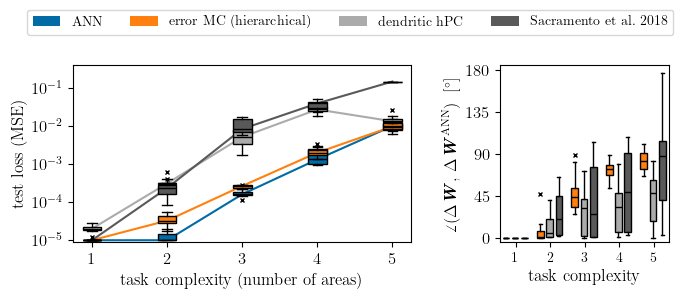

In [13]:
LINTRESH = 1e-5

fig, axes = plt.subplots(figsize=(pagewidth*cm_to_inch, pagewidth*cm_to_inch/2.3), ncols=2, gridspec_kw={'width_ratios': [2, 1]})

ax = axes[0]

ax.set_xlabel("task complexity (number of areas)")
ax.set_ylabel("test loss (MSE)")
if LINTRESH > 0:
    ax.set_yscale('symlog', linthresh=LINTRESH)
else:
    ax.set_yscale('log')

labels = []
colors = []
model_labels = []
for i, [MC_list, MC_list_untrained] in enumerate(network_MC_list_clean):
    if i % 4 == 0:
        model_label = 'ANN'
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
#         label = model_label + ' ' + str(MC_list[-1].layers)
        label = str(MC_list[-1].layers)
        model_labels.append(model_label)
        labels.append(label)
        colors.append(color)        
    elif i % 4 == 1:
        model_label = 'error MC (hierarchical)'
#         model_label = 'error MC (ours)'
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
#         label = model_label + ' ' + str(MC_list[-1].layers)
        label = str(MC_list[-1].layers)
        model_labels.append(model_label)
        labels.append(label)
        colors.append(color)
    elif i % 4 == 2:
        model_label = 'dendritic hPC'
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
#         label = model_label + ' ' + str(MC_list[-1].layers)
        label = str(MC_list[-1].layers)
        model_labels.append(model_label)
        labels.append(label)
        colors.append(color)
    elif i % 4 == 3:
        model_label = 'Sacramento et al.~2018'
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
#         label = model_label + ' ' + str(MC_list[-1].layers)
        label = str(MC_list[-1].layers)
        model_labels.append(model_label)
        labels.append(label)
        colors.append(color)



x_pos = np.arange(len(labels))

width = 0.35  # the width of the bars
multiplier = 0
x_pos = [width/2]
for i, ([data,untrained_data]) in enumerate(MSE_data):
#     print(i)
    if i == 0:
        pass
    elif i % 2 == 1:
        x_pos.append(x_pos[-1] + 0.0*width * 1.5)
    elif i % 2 == 0:
        x_pos.append(x_pos[-1] - 0.0* width * 1.5)
    if i > 0 and i % 4 == 0:
        x_pos[-1] += 2.0
#     ax.bar(x_pos[-1], np.median(untrained_data), align='center', capsize=4, color=colors[i], \
#            width=2*width, alpha=0.3, zorder=-10, error_kw={'alpha': 0.2}) # without error bars
        
MSE_trained_data = np.array([data[0] for data in MSE_data])
# print(len(MSE_trained_data), len(x_pos))
# make sure that small losses are plotted, too
MSE_trained_data[MSE_trained_data < LINTRESH] = LINTRESH
MSE_trained_data = [x for x in MSE_trained_data]

# print(MSE_trained_data.shape, x_pos.shape)

# connect medians
median_data = np.median(np.array(MSE_trained_data), axis=-1)
median_data = median_data.reshape(5,4).T
for i, y in enumerate(median_data):
    ax.plot(x_pos[i::4], y)

flierprops = dict(marker='x', markerfacecolor='None', markersize=3,  markeredgecolor='black')
bplot_mse = ax.boxplot(MSE_trained_data, positions=x_pos, patch_artist=True, flierprops=flierprops)

# fill with colors
for patch, color in zip(bplot_mse['boxes'], colors):
    patch.set_facecolor(color)
for median in bplot_mse['medians']:
    median.set_color('black')

# ax.set_xticks([])
ax.set_xticks(np.array(x_pos[1::4]))#-width)
# ax.set_xticklabels([l.replace(", ", "-") for l in labels[1::3]])#, rotation='90')
ax.set_xticklabels([l+1 for l in range(len(x_pos[1::4]))])#, rotation='90')

# yticks = np.concatenate((np.array([0]), 10.0**np.arange(-5,1)))
yticks = 10.0**np.arange(-5,1)

ax.set_yticks(yticks)
ax.set_ylim(yticks[0]*0.95, 0.4)

        
# plot labels once
for lab, c in zip(model_labels[:4], colors[:4]):
    # matplotlib bar doesn't like , so we set width = 0
    # https://github.com/matplotlib/matplotlib/issues/21506
    ax.bar([1],[1], label=lab, color=c, width=0, )

ax.legend(loc='upper center', bbox_to_anchor=(0.82, 1.35),
          ncol=4, fancybox=True, prop={'size': 10}, )#, shadow=True)

# ax.set_xlim([0.2, 16.46])
# leg = ax[1].legend(framealpha = 0.95, loc='upper center', handlelength=1.2, bbox_to_anchor=(0.11, 1.))#ncol=1, labelspacing=-1.1, bbox_to_anchor=(0.5, 1.5))



ax = axes[1]


plt.xlabel("task complexity")
plt.ylabel("$\\angle (\\Delta \\textbf{\\textit{W}} ,\, \\Delta \\textbf{\\textit{W}}^\\mathrm{ANN}) \;\; [^\circ]$")


x_pos = np.arange(len(labels))

width = 0.35  # the width of the bars
multiplier = 0
x_pos = [0]
arr = []
for i, data in enumerate(angle_data_arr):
    if i % 4 == 0:
        continue
    x_pos.append(x_pos[-1] + width * 2)
    if i == 1: x_pos = x_pos[1:]
    if i > 0 and i % 4 == 1:
        x_pos[-1] += 0.5
    arr.append(data)
#     ax.bar(x_pos[-1], mean, yerr=[[x] for x in std], align='center', capsize=5, color=colors[i], width=2*width)
#     ax.bar(x_pos[-1], mean, yerr=std, align='center', capsize=5, color=colors[i], width=2*width)

x_pos = np.round(x_pos, 2)
print(x_pos)
bplot = ax.boxplot([data.flatten() for data in arr], positions=x_pos, patch_artist=True, flierprops=flierprops)

# fill with colors
colors = [colors[x] for x in range(1,len(colors)) if x%4!=0]
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')

x_pos[::3] = [x+0.75 for x in x_pos[::3]]
ax.set_xticks(x_pos[::3])
ax.set_xticklabels([l+1 for l in range(len(x_pos[0::3]))])#, rotation='90')

#     ax.boxplot(data.flatten())#, positions=x_pos[-1])#align='center', capsize=4, color=colors[i], width=2*width)


# ax.yaxis.set_label_position("right")
# ax.yaxis.tick_right()


ax.set_yticks([0,45,90,135,180])

plt.xlim([0.75, 13.5])
ax.set_ylim(-5,185)
# leg = ax[1].legend(framealpha = 0.95, loc='upper center', handlelength=1.2, bbox_to_anchor=(0.11, 1.))#ncol=1, labelspacing=-1.1, bbox_to_anchor=(0.5, 1.5))
plt.xticks(fontsize=10)


plt.subplots_adjust(left=0.1, bottom=0.19, right=0.99, top=0.8, wspace=0.35, hspace=0.08)
plt.savefig(MAIN_PATH + "results_stacked.pdf")
plt.show()

# Figure 4: populations

In [4]:
# now load errormcs
MAIN_PATH = 'experiments/Fig4_populations/'

network_seed_MC_list = []
for i in range(200):
    try:
        model_file = MAIN_PATH + f'/runs/lr{i}/model.pkl'
        MC_list = src.save_exp.load(model_file)
        network_seed_MC_list.append(MC_list[0])
    except:
        pass

In [5]:
len(network_seed_MC_list)

160

In [6]:
# re-arrange into seeds
SEEDS = 10

network_MC_list = [network_seed_MC_list[i: i+SEEDS] for i in range(0, len(network_seed_MC_list), SEEDS)]

len(network_MC_list)

16

In [7]:
mean_test_arr = []
std_test_arr = []

n_rep_err_arr = []
n_rep = 4
n_err = 4

for MC_list in network_MC_list:
    
    # extract MSE
    data = np.array([mc.MSE_test_time_series for mc in MC_list])
    # mean across time
    data = np.mean(data, axis=-1)
#     # median across seeds
#     median = np.median(data)
#     q25, q75 = np.quantile(data, 0.25), np.quantile(data, 0.75)
    
#     mean_test_arr.append(median)
#     std_test_arr.append((q25, q75))
    
    # mean across seeds
    median = np.mean(data)
    std = np.std(data)
    
    mean_test_arr.append(median)
    std_test_arr.append(std)
    
    # save number of neurons
    n_rep_err_arr.append((MC_list[0].layers[1], MC_list[0].error_layers[1]))    
    
mean_test_arr = np.array(mean_test_arr).reshape(n_rep, n_err)
# std_test_arr = np.array(std_test_arr).reshape(n_rep, n_err, 2)
std_test_arr = np.array(std_test_arr).reshape(n_rep, n_err)
n_rep_err_arr = np.array(n_rep_err_arr).reshape(n_rep, n_err, 2)

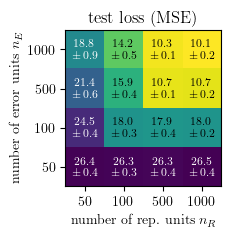

In [8]:
from matplotlib.pyplot import cm

fig, ax = plt.subplots(figsize=(pagewidth*cm_to_inch/2.5, pagewidth*cm_to_inch/3))
im = ax.imshow(mean_test_arr, cmap=cm.viridis_r)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(4))
ax.set_xticklabels(labels=n_rep_err_arr[:,0,0])
ax.set_yticks(np.arange(4))
ax.set_yticklabels(labels=n_rep_err_arr[0,:,1])

normalized_data = (mean_test_arr - np.min(mean_test_arr))/np.ptp(mean_test_arr)

# Loop over data dimensions and create text annotations
for i in range(len(mean_test_arr)):
    for j in range(len(mean_test_arr[0])):
#     for j in range(len(mean_test_arr[0])-1, -1, -1):
        
        mean = mean_test_arr[i, j]
        std = std_test_arr[i, j]
        
        text_color = 'white' if normalized_data[i,j] > 0.5 else 'black'
#         label_str = "$%.1f$" % mean + "\n $^{+ %.1f" % (std[0] - mean) + "}_{- %.1f" % (mean - std[1]) + "}$"
        label_str = "\quad $ %.1f$" % mean + "\n${\pm \, %.1f" % (std) + "}\,$"
        ax.text(j, i, label_str, ha="center", va="center", color=text_color, fontsize=8)

plt.xlabel("number of rep.~units $n_R$")
plt.ylabel("number of error units $n_E$")
ax.invert_yaxis()
plt.title("test loss (MSE)")
plt.subplots_adjust(left = 0.1, top = 0.9, right = 1.0, bottom = 0.2, hspace = 0.0, wspace = 0.0)
plt.savefig(MAIN_PATH + "MSE_nR_vs_nE.pdf")
plt.show()

label: (array([8]),)
MSE: 18.14249127086067


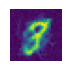

In [9]:
mc1 = network_MC_list[1][0]

for i, (r0, target) in enumerate(zip(mc1.input_testing, mc1.target_testing)):
    if np.any(r0 != label_to_onehot(8, 10)):
        continue
    mc1.evolve_system(r0=r0)
    if i % int(mc1.Tpres / mc1.dt) == int(mc1.Tpres / mc1.dt)-1:
        print("label:", np.where(r0==1))
        mse = np.linalg.norm(mc1.rP_breve[-1] - target)**2
        print("MSE:", mse)
        plt.subplots(figsize=(1.7*cm_to_inch, 1.7*cm_to_inch))
        plt.imshow(mc1.rP_breve[-1].reshape(28,28))
        plt.axis('off')
#         plt.title("$n_R=n_E=50$")
        plt.savefig(MAIN_PATH + "example_50_50.pdf")
        plt.show()

label: (array([8]),)
MSE: 0.9744818855001652


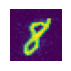

In [10]:
mc1 = network_MC_list[-1][0]

for i, (r0, target) in enumerate(zip(mc1.input_testing, mc1.target_testing)):
    if np.any(r0 != label_to_onehot(8, 10)):
        continue
    mc1.evolve_system(r0=r0)
    if i % int(mc1.Tpres / mc1.dt) == int(mc1.Tpres / mc1.dt)-1:
        print("label:", np.where(r0==1))
        mse = np.linalg.norm(mc1.rP_breve[-1] - target)**2
        print("MSE:", mse)
        plt.subplots(figsize=(1.7*cm_to_inch, 1.7*cm_to_inch))
        plt.imshow(mc1.rP_breve[-1].reshape(28,28))
        plt.axis('off')
#         plt.title("$n_R=n_E=50$")
        plt.savefig(MAIN_PATH + "example_1000_1000.pdf")
        plt.show()

# Figure 5: Noise plots

In [32]:
# now load errormcs
MAIN_PATHS = [
    'experiments/Fig5_rep_unit_noise/',
    'experiments/Fig5_error_unit_noise/',
]

network_seed_MC_list = []
for MAIN_PATH in MAIN_PATHS:
    for i in range(200):
        try:
            model_file = MAIN_PATH + f'/runs/lr{i}/model.pkl'
            MC_list = src.save_exp.load(model_file)
            network_seed_MC_list.append(MC_list[0])
        except:
            pass

In [33]:
len(network_seed_MC_list)

90

In [34]:
# re-arrange into seeds
SEEDS = 10

network_MC_list = [network_seed_MC_list[i: i+SEEDS] for i in range(0, len(network_seed_MC_list), SEEDS)]

len(network_MC_list)

9

In [35]:
mse_arr = []

for MC_list in network_MC_list:
    
    # extract MSE
    data = np.array([mc.MSE_test_time_series for mc in MC_list])
    # mean across time
    data = np.mean(data, axis=-1)
    
    mse_arr.append(data)
    
mse_arr = np.array(mse_arr)

mse_arr = mse_arr[[4,0,1,2,3,5,6,7,8],:]

In [36]:
noise_arr = [0.0, 0.1, 0.3, 0.5, 1.0]

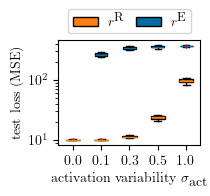

In [37]:
fig, ax = plt.subplots(figsize=(pagewidth*cm_to_inch/3.3, pagewidth*cm_to_inch/3.5))

ax.set_xlabel("activation variability $\\sigma_\\textrm{act}$")
ax.set_ylabel("test loss (MSE)")

flierprops = dict(marker='x', markerfacecolor='None', markersize=1,  markeredgecolor='red')
bplot_mse2 = ax.boxplot(mse_arr[5:].T, positions=range(1,len(noise_arr[1:])+1), patch_artist=True, flierprops=flierprops)
flierprops = dict(marker='x', markerfacecolor='None', markersize=1,  markeredgecolor='red')
bplot_mse = ax.boxplot(mse_arr[:5].T, positions=range(len(noise_arr)), patch_artist=True, flierprops=flierprops)
ax.set_xticks(range(len(noise_arr)))
ax.set_xticklabels(labels=noise_arr)

# fill with colors
for patch in bplot_mse['boxes']:
    patch.set_facecolor('C1')
for median in bplot_mse['medians']:
    median.set_color('C1')
# fill with colors
for patch in bplot_mse2['boxes']:
    patch.set_facecolor('C0')
for median in bplot_mse2['medians']:
    median.set_color('C0')
    
    
    # =\\varphi(\\breve{u}^\\textrm{som})
    # =\\varphi(\\breve{v}^\\textrm{som})
l = ax.legend([bplot_mse["boxes"][0], bplot_mse2["boxes"][0]], ['$r^\\textrm{R}$', '$r^\\textrm{E}$'], loc='upper center', prop={'size': 9}, ncol=2, bbox_to_anchor=(0.5,1.35), columnspacing=1)
for t in l.get_texts(): t.set_va('baseline')

plt.yscale('log')
plt.subplots_adjust(left = 0.25, top = 0.8, right = 0.95, bottom = 0.25, hspace = 0.2, wspace = 0.0)
# plt.savefig(MAIN_PATH + '/noise.pdf')
    
plt.show()

# Fig A2: Perfect SPS for sacramento and dPC

### Load microcircuits

In [4]:
MAIN_PATH = 'experiments/FigA2_multilayer_comparison_ideal_lat_inh/'
# MAIN_PATH = 'experiments/multilayer_comparison_compiled/'
PATHS = ['/2-1/','/4-2-1/','/8-4-2-1/','/16-8-4-2-1/','/32-16-8-4-2-1/']
PATH_APPENDIX = ['ann', 'errormc', 'dPC', 'sacramento2018', 'untrained_ann', 'untrained_errormc', 'untrained_dPC', 'untrained_sacramento2018']
NAME = ''

In [5]:
network_MC_list = []
for PATH in PATHS:
    for PATH_APP in PATH_APPENDIX:
        model_file = MAIN_PATH + PATH + '/' + PATH_APP + '/model.pkl'
        MC_list = src.save_exp.load(model_file)
        network_MC_list.append(MC_list)

In [6]:
# define the number of recorded time steps which belong to the pre-training
# and therefore should be skipped in plotting
TPRE = int(MC_list[0].settling_time / MC_list[0].dt / MC_list[0].rec_per_steps)

linestyles = ['dotted', 'dashdot', 'dashed','solid']
plt.rc('text', usetex=True)
plt.rc('font', size=12,family='serif')

LABEL_MULTIPLIER = int(1/ MC_list[0].rec_per_steps * MC_list[0].Tpres * MC_list[0].dataset_size / MC_list[0].dt)

In [7]:
# data_angle_BPP_RHS = []
# data_angle_WPPT_BPP = []
# data_angle_BP = []

# for mc in MC_list:
#     for data, arr in zip([data_angle_BPP_RHS, data_angle_WPPT_BPP, data_angle_BP], [mc.angle_BPP_RHS_time_series, mc.angle_WPPT_BPP_time_series, mc.angle_BP_updates_time_series]):
#         data.append(arr)

In [8]:
# np.save(PATH + "data_angle_BPP_RHS_" + NAME + ".npy", data_angle_BPP_RHS)
# np.save(PATH + "data_angle_WPPT_BPP_" + NAME + ".npy", data_angle_WPPT_BPP)
# np.save(PATH + "data_angle_BP_" + NAME + ".npy", data_angle_BP)

## Plots

Clean up the code and order different MCs:

In [9]:
network_MC_list_clean = []
tmp_MC_list = []

# skip teacher
tmp_MC_list = [MC_list[1:] for MC_list in network_MC_list]
     
# Step 1: Split the list into chunks of 8 elements
chunks = [tmp_MC_list[i:i+8] for i in range(0, len(tmp_MC_list), 8)]

# Step 2: Reorganize each chunk
result = []
for chunk in chunks:
    for i in range(4):  # 4 pairs in each chunk
        network_MC_list_clean.append([chunk[i], chunk[i+4]])
    

In [10]:
mean_std_arr = []
# the MSE needs a little bit to settle, which heavily distorts the MSE
# therefore, we skip a couple of dt
SKIP_SETTLING = 10

for i, [MC_list, MC_list_untrained] in enumerate(network_MC_list_clean):
    # extract MSE
    data = np.array([mc.MSE_test_time_series for mc in MC_list])
    data = data[:,SKIP_SETTLING:]
    # first, take mean over test accuracy (time)
    data = np.mean(data, axis=-1)
    
    # then, median over seeds
    mean = np.median(data)
    std  = (np.quantile(data, q=.25), np.quantile(data, q=.75))
#     std  = (np.std(data))
    
    # extract MSE
    data_untrnd = np.array([mc.MSE_test_time_series for mc in MC_list_untrained])
    data_untrnd = data_untrnd[:,SKIP_SETTLING:]
    # first, take mean over test accuracy (time)
    data_untrnd = np.mean(data_untrnd, axis=-1)
    
    # then, median over seeds
    mean_untrained = np.median(data_untrnd)
    std_untrained  = (np.quantile(data_untrnd, q=.25), np.quantile(data_untrnd, q=.75))
#     std_untrained  = (np.std(data))
    
    mean_std_arr.append([[mean, std], [mean_untrained, std_untrained]])
# mean_std_arr = np.array(mean_std_arr)

## combined

In [11]:
MSE_data = []
# the MSE needs a little bit to settle, which heavily distorts the MSE
# therefore, we skip a couple of dt
SKIP_SETTLING = 10

for i, [MC_list, MC_list_untrained] in enumerate(network_MC_list_clean):
    # extract MSE
    data = np.array([mc.MSE_test_time_series for mc in MC_list])
    data = data[:,SKIP_SETTLING:]
    # first, take mean over test accuracy (time)
    data = np.mean(data, axis=-1)
    
    # extract MSE
    data_untrnd = np.array([mc.MSE_test_time_series for mc in MC_list_untrained])
    data_untrnd = data_untrnd[:,SKIP_SETTLING:]
    # first, take mean over test accuracy (time)
    data_untrnd = np.mean(data_untrnd, axis=-1)
    
    MSE_data.append([data, data_untrnd])
# mean_std_arr = np.array(mean_std_arr)

In [12]:
angle_data_arr = []

for i, MC_list in enumerate(network_MC_list_clean):
#     # skip ANN
#     if i % 3 == 0:
#         continue
    angle_data = [MC_list[0][i].angle_BP_updates_time_series for i in range(len(MC_list[0]))]
    angle_data = np.array(angle_data)
    # replace nan with 0 (can occur due to underflow)
    angle_data = np.nan_to_num(angle_data)
    # mean over time
    angle_data = np.mean(angle_data, axis=1)
    
#     mean = np.mean(angle_data)
#     std  = (np.quantile(angle_data, q=.25), np.quantile(angle_data, q=.75))
#     #     std  = np.std(angle_data)
    
    angle_data_arr.append(angle_data)

[ 1.2  1.9  2.6  3.8  4.5  5.2  6.4  7.1  7.8  9.   9.7 10.4 11.6 12.3
 13. ]


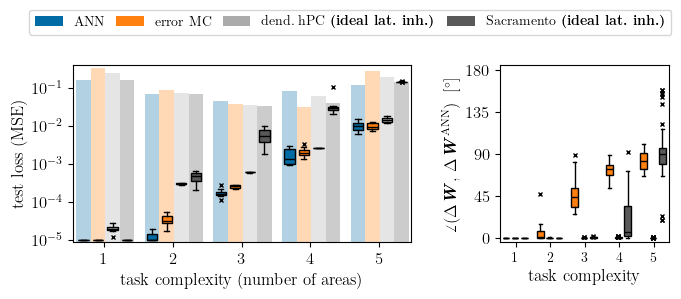

In [13]:
LINTRESH = 1e-5

fig, axes = plt.subplots(figsize=(pagewidth*cm_to_inch, pagewidth*cm_to_inch/2.3), ncols=2, gridspec_kw={'width_ratios': [2, 1]})

ax = axes[0]

ax.set_xlabel("task complexity (number of areas)")
ax.set_ylabel("test loss (MSE)")
if LINTRESH > 0:
    ax.set_yscale('symlog', linthresh=LINTRESH)
else:
    ax.set_yscale('log')

labels = []
colors = []
model_labels = []
for i, [MC_list, MC_list_untrained] in enumerate(network_MC_list_clean):
    if i % 4 == 0:
        model_label = 'ANN'
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
#         label = model_label + ' ' + str(MC_list[-1].layers)
        label = str(MC_list[-1].layers)
        model_labels.append(model_label)
        labels.append(label)
        colors.append(color)        
    elif i % 4 == 1:
        model_label = 'error MC'
#         model_label = 'error MC (ours)'
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
#         label = model_label + ' ' + str(MC_list[-1].layers)
        label = str(MC_list[-1].layers)
        model_labels.append(model_label)
        labels.append(label)
        colors.append(color)
    elif i % 4 == 2:
        model_label = 'dend.~hPC \\textbf{(ideal lat.~inh.)}'
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
#         label = model_label + ' ' + str(MC_list[-1].layers)
        label = str(MC_list[-1].layers)
        model_labels.append(model_label)
        labels.append(label)
        colors.append(color)
    elif i % 4 == 3:
        model_label = 'Sacramento \\textbf{(ideal lat.~inh.)}'
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
#         label = model_label + ' ' + str(MC_list[-1].layers)
        label = str(MC_list[-1].layers)
        model_labels.append(model_label)
        labels.append(label)
        colors.append(color)



x_pos = np.arange(len(labels))

width = 0.35  # the width of the bars
multiplier = 0
x_pos = [0]
for i, ([data,untrained_data]) in enumerate(MSE_data):
   
    x_pos.append(x_pos[-1] + width * 2)
    if i == 0: x_pos = x_pos[1:]
    if i > 0 and i % 4 == 0:
        x_pos[-1] += 0.5
    ax.bar(x_pos[-1], np.median(untrained_data), align='center', capsize=4, color=colors[i], \
           width=2*width, alpha=0.3, zorder=-10, error_kw={'alpha': 0.2}) # without error bars
        
MSE_trained_data = np.array([data[0] for data in MSE_data])
# print(len(MSE_trained_data), len(x_pos))
# make sure that small losses are plotted, too
MSE_trained_data[MSE_trained_data < LINTRESH] = LINTRESH
MSE_trained_data = [x for x in MSE_trained_data]

# print(MSE_trained_data.shape, x_pos.shape)

flierprops = dict(marker='x', markerfacecolor='None', markersize=3,  markeredgecolor='black')
bplot_mse = ax.boxplot(MSE_trained_data, positions=x_pos, patch_artist=True, flierprops=flierprops)

# fill with colors
for patch, color in zip(bplot_mse['boxes'], colors):
    patch.set_facecolor(color)
for median in bplot_mse['medians']:
    median.set_color('black')

# ax.set_xticks([])
ax.set_xticks(np.array(x_pos[1::4])+0.3)
# ax.set_xticklabels([l.replace(", ", "-") for l in labels[1::3]])#, rotation='90')
ax.set_xticklabels([l+1 for l in range(len(x_pos[1::4]))])#, rotation='90')

# yticks = np.concatenate((np.array([0]), 10.0**np.arange(-5,1)))
yticks = 10.0**np.arange(-5,1)

ax.set_yticks(yticks)
ax.set_ylim(yticks[0]*0.95, 0.4)

        
# plot labels once
for lab, c in zip(model_labels[:4], colors[:4]):
    # matplotlib bar doesn't like , so we set width = 0
    # https://github.com/matplotlib/matplotlib/issues/21506
    ax.bar([1],[1], label=lab, color=c, width=0, )

ax.legend(loc='upper center', bbox_to_anchor=(0.82, 1.35),
          ncol=4, fancybox=True, prop={'size': 10}, columnspacing=0.8)#, shadow=True)

ax.set_xlim([0.2, 16.46])
# leg = ax[1].legend(framealpha = 0.95, loc='upper center', handlelength=1.2, bbox_to_anchor=(0.11, 1.))#ncol=1, labelspacing=-1.1, bbox_to_anchor=(0.5, 1.5))



ax = axes[1]


plt.xlabel("task complexity")
plt.ylabel("$\\angle (\\Delta \\textbf{\\textit{W}} ,\, \\Delta \\textbf{\\textit{W}}^\\mathrm{ANN}) \;\; [^\circ]$")


x_pos = np.arange(len(labels))

width = 0.35  # the width of the bars
multiplier = 0
x_pos = [0]
arr = []
for i, data in enumerate(angle_data_arr):
    if i % 4 == 0:
        continue
    x_pos.append(x_pos[-1] + width * 2)
    if i == 1: x_pos = x_pos[1:]
    if i > 0 and i % 4 == 1:
        x_pos[-1] += 0.5
    arr.append(data)
#     ax.bar(x_pos[-1], mean, yerr=[[x] for x in std], align='center', capsize=5, color=colors[i], width=2*width)
#     ax.bar(x_pos[-1], mean, yerr=std, align='center', capsize=5, color=colors[i], width=2*width)

x_pos = np.round(x_pos, 2)
print(x_pos)
bplot = ax.boxplot([data.flatten() for data in arr], positions=x_pos, patch_artist=True, flierprops=flierprops)

# fill with colors
colors = [colors[x] for x in range(1,len(colors)) if x%4!=0]
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')

x_pos[::3] = [x+0.75 for x in x_pos[::3]]
ax.set_xticks(x_pos[::3])
ax.set_xticklabels([l+1 for l in range(len(x_pos[0::3]))])#, rotation='90')

#     ax.boxplot(data.flatten())#, positions=x_pos[-1])#align='center', capsize=4, color=colors[i], width=2*width)


# ax.yaxis.set_label_position("right")
# ax.yaxis.tick_right()


ax.set_yticks([0,45,90,135,180])

plt.xlim([0.75, 13.5])
ax.set_ylim(-5,185)
# leg = ax[1].legend(framealpha = 0.95, loc='upper center', handlelength=1.2, bbox_to_anchor=(0.11, 1.))#ncol=1, labelspacing=-1.1, bbox_to_anchor=(0.5, 1.5))
plt.xticks(fontsize=10)


plt.subplots_adjust(left=0.1, bottom=0.19, right=0.99, top=0.8, wspace=0.35, hspace=0.08)
plt.savefig(MAIN_PATH + "results.pdf")
plt.show()

## Stacked plots

[ 1.2  1.9  2.6  3.8  4.5  5.2  6.4  7.1  7.8  9.   9.7 10.4 11.6 12.3
 13. ]


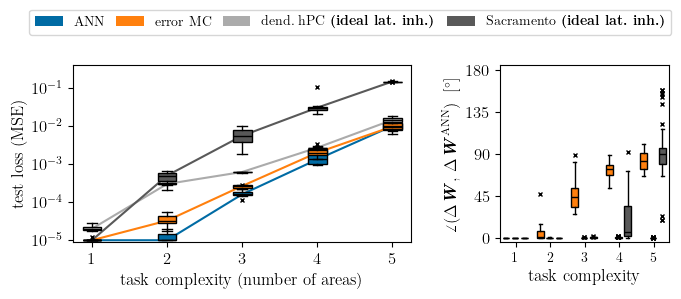

In [14]:
LINTRESH = 1e-5

fig, axes = plt.subplots(figsize=(pagewidth*cm_to_inch, pagewidth*cm_to_inch/2.3), ncols=2, gridspec_kw={'width_ratios': [2, 1]})

ax = axes[0]

ax.set_xlabel("task complexity (number of areas)")
ax.set_ylabel("test loss (MSE)")
if LINTRESH > 0:
    ax.set_yscale('symlog', linthresh=LINTRESH)
else:
    ax.set_yscale('log')

labels = []
colors = []
model_labels = []
for i, [MC_list, MC_list_untrained] in enumerate(network_MC_list_clean):
    if i % 4 == 0:
        model_label = 'ANN'
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
#         label = model_label + ' ' + str(MC_list[-1].layers)
        label = str(MC_list[-1].layers)
        model_labels.append(model_label)
        labels.append(label)
        colors.append(color)        
    elif i % 4 == 1:
        model_label = 'error MC'
#         model_label = 'error MC (ours)'
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
#         label = model_label + ' ' + str(MC_list[-1].layers)
        label = str(MC_list[-1].layers)
        model_labels.append(model_label)
        labels.append(label)
        colors.append(color)
    elif i % 4 == 2:
        model_label = 'dend.~hPC \\textbf{(ideal lat.~inh.)}'
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
#         label = model_label + ' ' + str(MC_list[-1].layers)
        label = str(MC_list[-1].layers)
        model_labels.append(model_label)
        labels.append(label)
        colors.append(color)
    elif i % 4 == 3:
        model_label = 'Sacramento \\textbf{(ideal lat.~inh.)}'
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
#         label = model_label + ' ' + str(MC_list[-1].layers)
        label = str(MC_list[-1].layers)
        model_labels.append(model_label)
        labels.append(label)
        colors.append(color)



x_pos = np.arange(len(labels))

width = 0.35  # the width of the bars
multiplier = 0
x_pos = [width/2]
for i, ([data,untrained_data]) in enumerate(MSE_data):
#     print(i)
    if i == 0:
        pass
    elif i % 2 == 1:
        x_pos.append(x_pos[-1] + 0.0*width * 1.5)
    elif i % 2 == 0:
        x_pos.append(x_pos[-1] - 0.0* width * 1.5)
    if i > 0 and i % 4 == 0:
        x_pos[-1] += 2.0
#     ax.bar(x_pos[-1], np.median(untrained_data), align='center', capsize=4, color=colors[i], \
#            width=2*width, alpha=0.3, zorder=-10, error_kw={'alpha': 0.2}) # without error bars
        
MSE_trained_data = np.array([data[0] for data in MSE_data])
# print(len(MSE_trained_data), len(x_pos))
# make sure that small losses are plotted, too
MSE_trained_data[MSE_trained_data < LINTRESH] = LINTRESH
MSE_trained_data = [x for x in MSE_trained_data]

# print(MSE_trained_data.shape, x_pos.shape)

# connect medians
median_data = np.median(np.array(MSE_trained_data), axis=-1)
median_data = median_data.reshape(5,4).T
for i, y in enumerate(median_data):
    ax.plot(x_pos[i::4], y)

flierprops = dict(marker='x', markerfacecolor='None', markersize=3,  markeredgecolor='black')
bplot_mse = ax.boxplot(MSE_trained_data, positions=x_pos, patch_artist=True, flierprops=flierprops)

# fill with colors
for patch, color in zip(bplot_mse['boxes'], colors):
    patch.set_facecolor(color)
for median in bplot_mse['medians']:
    median.set_color('black')

# ax.set_xticks([])
ax.set_xticks(np.array(x_pos[1::4]))#-width)
# ax.set_xticklabels([l.replace(", ", "-") for l in labels[1::3]])#, rotation='90')
ax.set_xticklabels([l+1 for l in range(len(x_pos[1::4]))])#, rotation='90')

# yticks = np.concatenate((np.array([0]), 10.0**np.arange(-5,1)))
yticks = 10.0**np.arange(-5,1)

ax.set_yticks(yticks)
ax.set_ylim(yticks[0]*0.95, 0.4)

        
# plot labels once
for lab, c in zip(model_labels[:4], colors[:4]):
    # matplotlib bar doesn't like , so we set width = 0
    # https://github.com/matplotlib/matplotlib/issues/21506
    ax.bar([1],[1], label=lab, color=c, width=0, )

ax.legend(loc='upper center', bbox_to_anchor=(0.82, 1.35),
          ncol=4, fancybox=True, prop={'size': 10}, columnspacing=0.8)#, shadow=True)

# ax.set_xlim([0.2, 16.46])
# leg = ax[1].legend(framealpha = 0.95, loc='upper center', handlelength=1.2, bbox_to_anchor=(0.11, 1.))#ncol=1, labelspacing=-1.1, bbox_to_anchor=(0.5, 1.5))



ax = axes[1]


plt.xlabel("task complexity")
plt.ylabel("$\\angle (\\Delta \\textbf{\\textit{W}} ,\, \\Delta \\textbf{\\textit{W}}^\\mathrm{ANN}) \;\; [^\circ]$")


x_pos = np.arange(len(labels))

width = 0.35  # the width of the bars
multiplier = 0
x_pos = [0]
arr = []
for i, data in enumerate(angle_data_arr):
    if i % 4 == 0:
        continue
    x_pos.append(x_pos[-1] + width * 2)
    if i == 1: x_pos = x_pos[1:]
    if i > 0 and i % 4 == 1:
        x_pos[-1] += 0.5
    arr.append(data)
#     ax.bar(x_pos[-1], mean, yerr=[[x] for x in std], align='center', capsize=5, color=colors[i], width=2*width)
#     ax.bar(x_pos[-1], mean, yerr=std, align='center', capsize=5, color=colors[i], width=2*width)

x_pos = np.round(x_pos, 2)
print(x_pos)
bplot = ax.boxplot([data.flatten() for data in arr], positions=x_pos, patch_artist=True, flierprops=flierprops)

# fill with colors
colors = [colors[x] for x in range(1,len(colors)) if x%4!=0]
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set_color('black')

x_pos[::3] = [x+0.75 for x in x_pos[::3]]
ax.set_xticks(x_pos[::3])
ax.set_xticklabels([l+1 for l in range(len(x_pos[0::3]))])#, rotation='90')

#     ax.boxplot(data.flatten())#, positions=x_pos[-1])#align='center', capsize=4, color=colors[i], width=2*width)


# ax.yaxis.set_label_position("right")
# ax.yaxis.tick_right()


ax.set_yticks([0,45,90,135,180])

plt.xlim([0.75, 13.5])
ax.set_ylim(-5,185)
# leg = ax[1].legend(framealpha = 0.95, loc='upper center', handlelength=1.2, bbox_to_anchor=(0.11, 1.))#ncol=1, labelspacing=-1.1, bbox_to_anchor=(0.5, 1.5))
plt.xticks(fontsize=10)


plt.subplots_adjust(left=0.1, bottom=0.19, right=0.99, top=0.8, wspace=0.35, hspace=0.08)
plt.savefig(MAIN_PATH + "results_stacked.pdf")
plt.show()

# Fig C1: non-linearities and dPC 

In [39]:
MAIN_PATH = 'experiments/'
PATHS = ['FigC1_dPC_linear', 'FigC1_dPC_nonlin_noUS/', 'FigC1_dPC_nonlin_US']
PATH_APPENDIX = ['/2-1/','/4-2-1/','/8-4-2-1/','/16-8-4-2-1/','/32-16-8-4-2-1/']
PATH_APPENDIX2 = ['dPC', 'untrained_dPC']
NAME = ''

In [40]:
network_MC_list = []
for PATH_APP in PATH_APPENDIX:
    for PATH_APP2 in PATH_APPENDIX2:
        for PATH in PATHS:
            model_file = MAIN_PATH + PATH + '/' + PATH_APP + PATH_APP2 + '/model.pkl'
            MC_list = src.save_exp.load(model_file)
            network_MC_list.append(MC_list)

In [41]:
network_MC_list_clean = []
tmp_MC_list = []

# skip teacher
tmp_MC_list = [MC_list[1:] for MC_list in network_MC_list]
     
# Step 1: Split the list into chunks of 6 elements
chunks = [tmp_MC_list[i:i+6] for i in range(0, len(tmp_MC_list), 6)]

# Step 2: Reorganize each chunk
result = []
for chunk in chunks:
    for i in range(3):  # 3 pairs in each chunk
        network_MC_list_clean.append([chunk[i], chunk[i+3]])
    

In [42]:
MSE_data = []
# the MSE needs a little bit to settle, which heavily distorts the MSE
# therefore, we skip a couple of dt
SKIP_SETTLING = 10

for i, [MC_list, MC_list_untrained] in enumerate(network_MC_list_clean):
    # extract MSE
    data = np.array([mc.MSE_test_time_series for mc in MC_list])
    data = data[:,SKIP_SETTLING:]
    # first, take mean over test accuracy (time)
    data = np.mean(data, axis=-1)
    
    # extract MSE
    data_untrnd = np.array([mc.MSE_test_time_series for mc in MC_list_untrained])
    data_untrnd = data_untrnd[:,SKIP_SETTLING:]
    # first, take mean over test accuracy (time)
    data_untrnd = np.mean(data_untrnd, axis=-1)
    
    MSE_data.append([data, data_untrnd])
# mean_std_arr = np.array(mean_std_arr)

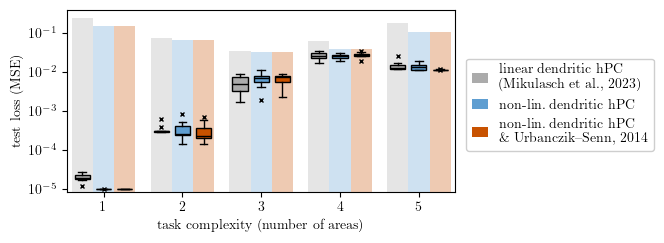

In [43]:
LINTRESH = 1e-5

fig, axes = plt.subplots(figsize=(pagewidth*cm_to_inch, pagewidth*cm_to_inch/2.8), ncols=1)

ax = axes

ax.set_xlabel("task complexity (number of areas)")
ax.set_ylabel("test loss (MSE)")
if LINTRESH > 0:
    ax.set_yscale('symlog', linthresh=LINTRESH)
else:
    ax.set_yscale('log')

labels = []
colors = []
model_labels = []
for i, [MC_list, MC_list_untrained] in enumerate(network_MC_list_clean):
    if i % 3 == 0:
        model_label = 'linear dendritic hPC \n (Mikulasch et al., 2023)'
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
#         label = model_label + ' ' + str(MC_list[-1].layers)
        label = str(MC_list[-1].layers)
        model_labels.append(model_label)
        labels.append(label)
        colors.append(color)        
    elif i % 3 == 1:
        model_label = 'non-lin.~dendritic hPC'
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][4]
#         label = model_label + ' ' + str(MC_list[-1].layers)
        label = str(MC_list[-1].layers)
        model_labels.append(model_label)
        labels.append(label)
        colors.append(color)
    elif i % 3 == 2:
        model_label = 'non-lin.~dendritic hPC \n \& Urbanczik--Senn, 2014'
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][5]
#         label = model_label + ' ' + str(MC_list[-1].layers)
        label = str(MC_list[-1].layers)
        model_labels.append(model_label)
        labels.append(label)
        colors.append(color)



x_pos = np.arange(len(labels))

width = 0.35  # the width of the bars
multiplier = 0
x_pos = [0]
for i, ([data,untrained_data]) in enumerate(MSE_data):
   
    x_pos.append(x_pos[-1] + width * 2)
    if i == 0: x_pos = x_pos[1:]
    if i > 0 and i % 3 == 0:
        x_pos[-1] += 0.5
    ax.bar(x_pos[-1], np.median(untrained_data), align='center', capsize=4, color=colors[i], \
           width=2*width, alpha=0.3, zorder=-10, error_kw={'alpha': 0.2}) # without error bars
        
MSE_trained_data = np.array([data[0] for data in MSE_data])
# print(len(MSE_trained_data), len(x_pos))
# make sure that small losses are plotted, too
MSE_trained_data[MSE_trained_data < LINTRESH] = LINTRESH
MSE_trained_data = [x for x in MSE_trained_data]

# print(MSE_trained_data.shape, x_pos.shape)

flierprops = dict(marker='x', markerfacecolor='None', markersize=3,  markeredgecolor='black')
bplot_mse = ax.boxplot(MSE_trained_data, positions=x_pos, patch_artist=True, flierprops=flierprops)

# fill with colors
for patch, color in zip(bplot_mse['boxes'], colors):
    patch.set_facecolor(color)
for median in bplot_mse['medians']:
    median.set_color('black')

# ax.set_xticks([])
ax.set_xticks(x_pos[1::3])
# ax.set_xticklabels([l.replace(", ", "-") for l in labels[1::3]])#, rotation='90')
ax.set_xticklabels([l+1 for l in range(len(x_pos[1::3]))])#, rotation='90')

# yticks = np.concatenate((np.array([0]), 10.0**np.arange(-5,1)))
yticks = 10.0**np.arange(-5,1)

ax.set_yticks(yticks)
ax.set_ylim(yticks[0]*0.95, 0.4)

        
# plot labels once
for lab, c in zip(model_labels[:3], colors[:3]):
    # matplotlib bar doesn't like , so we set width = 0
    # https://github.com/matplotlib/matplotlib/issues/21506
    ax.bar([1],[1], label=lab, color=c, width=0, )

# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.24),
#           ncol=3, fancybox=True, prop={'size': 10}, )#, shadow=True)

ax.set_xlim([0.2, 13])
leg = ax.legend(framealpha = 0.95, loc='upper center', handlelength=1.2, bbox_to_anchor=(1.27, 0.77), prop={'size': 10})#ncol=1, labelspacing=-1.1, bbox_to_anchor=(0.5, 1.5))



# plt.tight_layout()
plt.subplots_adjust(left=0.1, bottom=0.19, right=0.68, top=0.95, wspace=0.35, hspace=0.08)
plt.savefig(MAIN_PATH + "comparison_dPC.pdf")
plt.show()